In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from src.plotting.plotting import bar_plot, ecdf_plot, boxplot_plot
import warnings
import pingouin as pg
import math 

# supressing warnings
warnings.filterwarnings("ignore")

mpl.rcParams["figure.dpi"] = 120
sns.set_style("whitegrid")
sns.set_palette("deep")


In [2]:
# data
fraud_detect_df = pd.read_csv("data/fraud_detection_dataset.csv")
fraud_detect_df.columns = ["step", "type", "amount", "name_orig", "old_balance_orig", "new_balance_orig", "name_dest", "old_balance_dest", "new_balance_dest", "is_fraud", "is_flagged_fraud"]

# change the order, last columns with the target
fraud_detect_df = fraud_detect_df[['step', 'type', 'amount', 'name_orig', 'old_balance_orig',
       'new_balance_orig', 'name_dest', 'old_balance_dest', 'new_balance_dest', 'is_flagged_fraud',
       'is_fraud']]

In [3]:
# our dataframe
fraud_detect_df

,step,type,amount,name_orig,old_balance_orig,new_balance_orig,name_dest,old_balance_dest,new_balance_dest,is_flagged_fraud,is_fraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,0,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,0,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,0,1
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,0,1
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,0,1
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,0,1


## How unbalanced is our data?

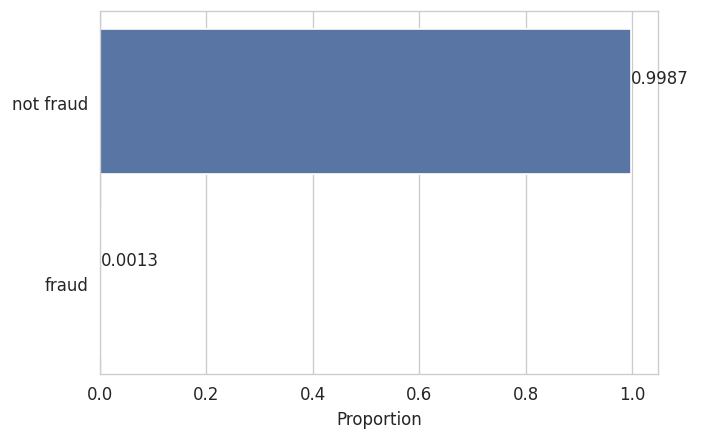

In [4]:
balance_df = fraud_detect_df["is_fraud"].value_counts(normalize=True).reset_index()
balance_df["index"] = balance_df["index"].replace({0: "not fraud", 1: "fraud"})
balance_df["is_fraud"] = round(balance_df["is_fraud"], 4)

bar_plot(balance_df, x="is_fraud", y="index", xlabel="Proportion", ylabel="")


## How `is_fraud` is distributed on our categorical variable `type`?

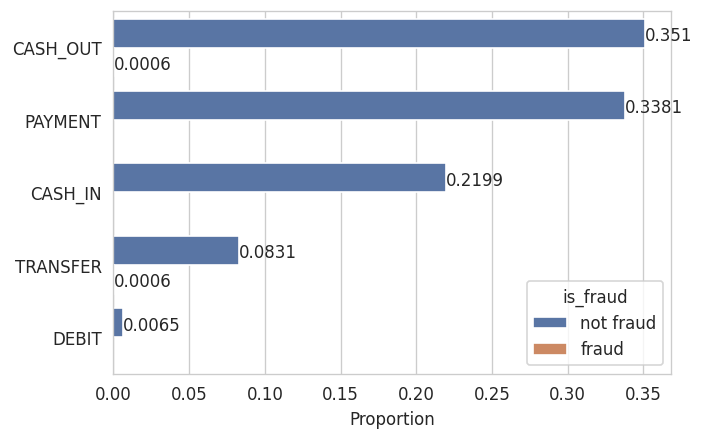

In [5]:
type_by_fraud_df = fraud_detect_df[["type", "is_fraud"]].value_counts(normalize=True).reset_index()
type_by_fraud_df.columns = ["type", "is_fraud", "prop"]
type_by_fraud_df["is_fraud"] = type_by_fraud_df["is_fraud"].replace({0: "not fraud", 1: "fraud"})
type_by_fraud_df["prop"] = round(type_by_fraud_df["prop"], 4)

bar_plot(type_by_fraud_df, x="prop", y="type", xlabel="Proportion", ylabel="", hue="is_fraud")


Let's perform a Chi2 test, and check if this variable if the correlation with our target (`is_fraud`) is significant (our alternative hypothesis).

In [6]:
observed, expected, stats = pg.chi2_independence(fraud_detect_df, x="type", y="is_fraud")
stats.round(4)


,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.0000,22082.5357,4.0,0.0,0.0589,1.0
1,cressie-read,0.6667,18858.3986,4.0,0.0,0.0544,1.0
2,log-likelihood,0.0000,17565.9133,4.0,0.0,0.0525,1.0
3,freeman-tukey,-0.5000,NaN,4.0,NaN,NaN,NaN
4,mod-log-likelihood,-1.0000,inf,4.0,0.0,inf,1.0
5,neyman,-2.0000,NaN,4.0,NaN,NaN,NaN


As wee see, this is a nice variable to add to our model, very low p-values on different tests.

## What about the variable `is_flagged_fraud`?

In [7]:
is_ff_df = fraud_detect_df["is_flagged_fraud"].value_counts().reset_index()
is_ff_df.columns = ["is_fraud", "count"]
is_ff_df

,is_fraud,count
0,0,6362604
1,1,16


This variable is not representative, for now wi'll just drop it.

In [8]:
fraud_detect_df.drop(["is_flagged_fraud"], axis=1, inplace=True)

## Let's look at the amount variable

We'll be using the ECDF plot here because the size of the dataset is too large, and because of the scale, is really difficult to see, in a meaningful way, the distribution.

The ECDF plot will bring on y-axis the percentiles, and x-axis your values for the numeric variable.

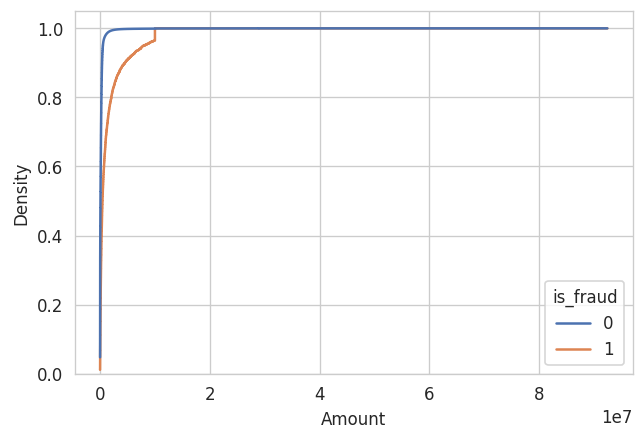

In [9]:
ecdf_plot(data=fraud_detect_df, x="amount", xlabel="Amount", ylabel="Density", hue="is_fraud")

Both of the distributions are skewed to the left, and in 60% of the time will be very difficult to distinguish if is fraud or not, based on those values. So, lets bring those variables to a more normal distribution applying the log transformation.

In [10]:
# applying log transformation on this variable
def log_transform(x):
    log_transformed = np.log(x + 1)
    return log_transformed

fraud_detect_df["amount_log"] = fraud_detect_df["amount"].apply(log_transform)
fraud_detect_df

,step,type,amount,name_orig,old_balance_orig,new_balance_orig,name_dest,old_balance_dest,new_balance_dest,is_fraud,amount_log
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,9.194276
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,7.531166
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,5.204007
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,5.204007
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,9.364703
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,12.735768
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,15.657870
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,15.657870
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,13.652996


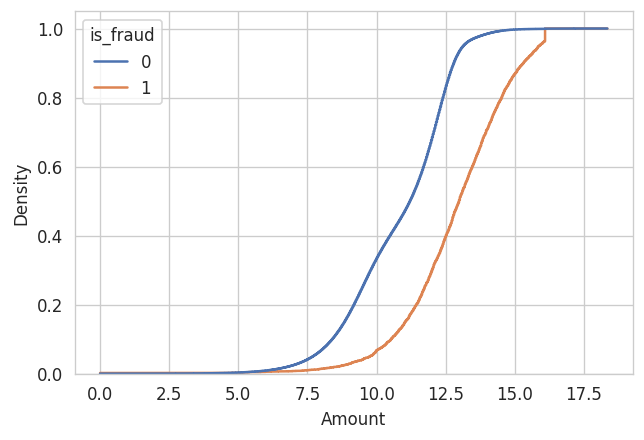

In [11]:
# let's see for the amount after the transformation
ecdf_plot(data=fraud_detect_df, x="amount_log", xlabel="Amount", ylabel="Density", hue="is_fraud")

Now, in most of the cases we can clearly see that exist difference between fraud and not fraud based on log transformed values of the `amount` category. Observing those values as a boxplot, we can see the difference on the medians and infer that those distributions are really different.

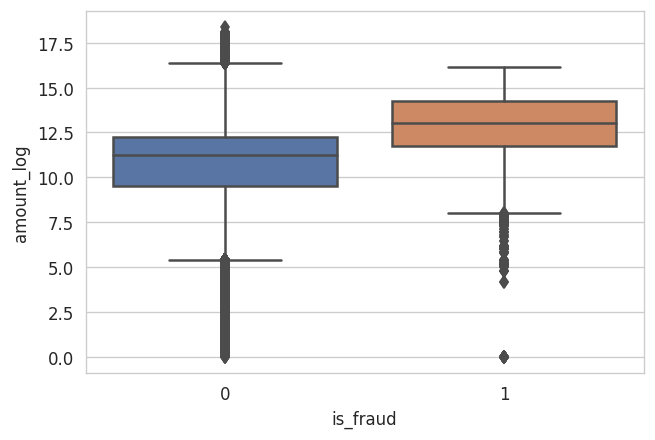

In [12]:
_ = sns.boxplot(x="is_fraud", y="amount_log", data=fraud_detect_df)
plt.show()

So, seems reasonable that we use `amount_log` the rest of the analysis.

In [13]:
# droping amount variable
fraud_detect_df.drop(["amount"], axis=1, inplace=True)
fraud_detect_df

,step,type,name_orig,old_balance_orig,new_balance_orig,name_dest,old_balance_dest,new_balance_dest,is_fraud,amount_log
0,1,PAYMENT,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,9.194276
1,1,PAYMENT,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,7.531166
2,1,TRANSFER,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,5.204007
3,1,CASH_OUT,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,5.204007
4,1,PAYMENT,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,9.364703
...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,12.735768
6362616,743,TRANSFER,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,15.657870
6362617,743,CASH_OUT,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,15.657870
6362618,743,TRANSFER,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,13.652996


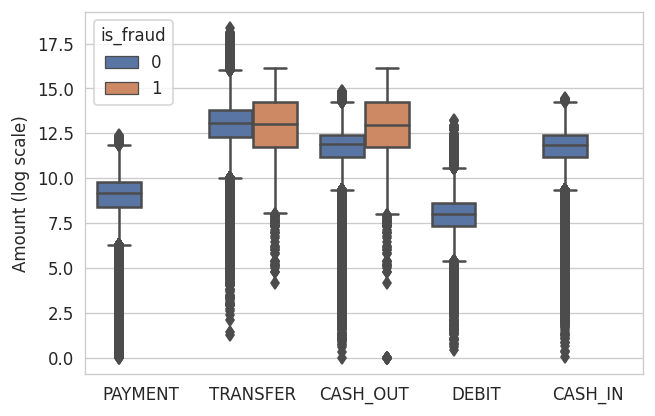

In [14]:
# let's check this variable related to the type of the transaction
boxplot_plot(
    data=fraud_detect_df,
    x="type",
    y="amount_log",
    hue="is_fraud",
    xlabel="",
    ylabel="Amount (log scale)",
)


In most of the cases we can see a clear distinction between `type`, `amount` and `is_fraud`. But, for `TRANSFER` class, the distributions are very similar. Maybe if we remove some lower outliers we could improve the distinction between those distributions, for now, we'll continue without handling outliers.

## How the hour of the transaction is related to `is_fraud`?

The `step` variable is the hour of the transaction. So we can also create another variable regarding the day of the month that those ours represent, and perform our analyse on both variables.

In [15]:
def get_day(x: int):
    division = x / 24
    dom = math.ceil(division)
    return dom

fraud_detect_df["day_of_month"] = fraud_detect_df["step"].apply(get_day)
fraud_detect_df

,step,type,name_orig,old_balance_orig,new_balance_orig,name_dest,old_balance_dest,new_balance_dest,is_fraud,amount_log,day_of_month
0,1,PAYMENT,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,9.194276,1
1,1,PAYMENT,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,7.531166,1
2,1,TRANSFER,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,5.204007,1
3,1,CASH_OUT,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,5.204007,1
4,1,PAYMENT,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,9.364703,1
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,12.735768,31
6362616,743,TRANSFER,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,15.657870,31
6362617,743,CASH_OUT,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,15.657870,31
6362618,743,TRANSFER,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,13.652996,31


Now, we'll see how this variable is related to `is_fraud` and the `amount_log`, but also we'll look at the boxplot for each of the classes on `type` that have fraud on the observation. 

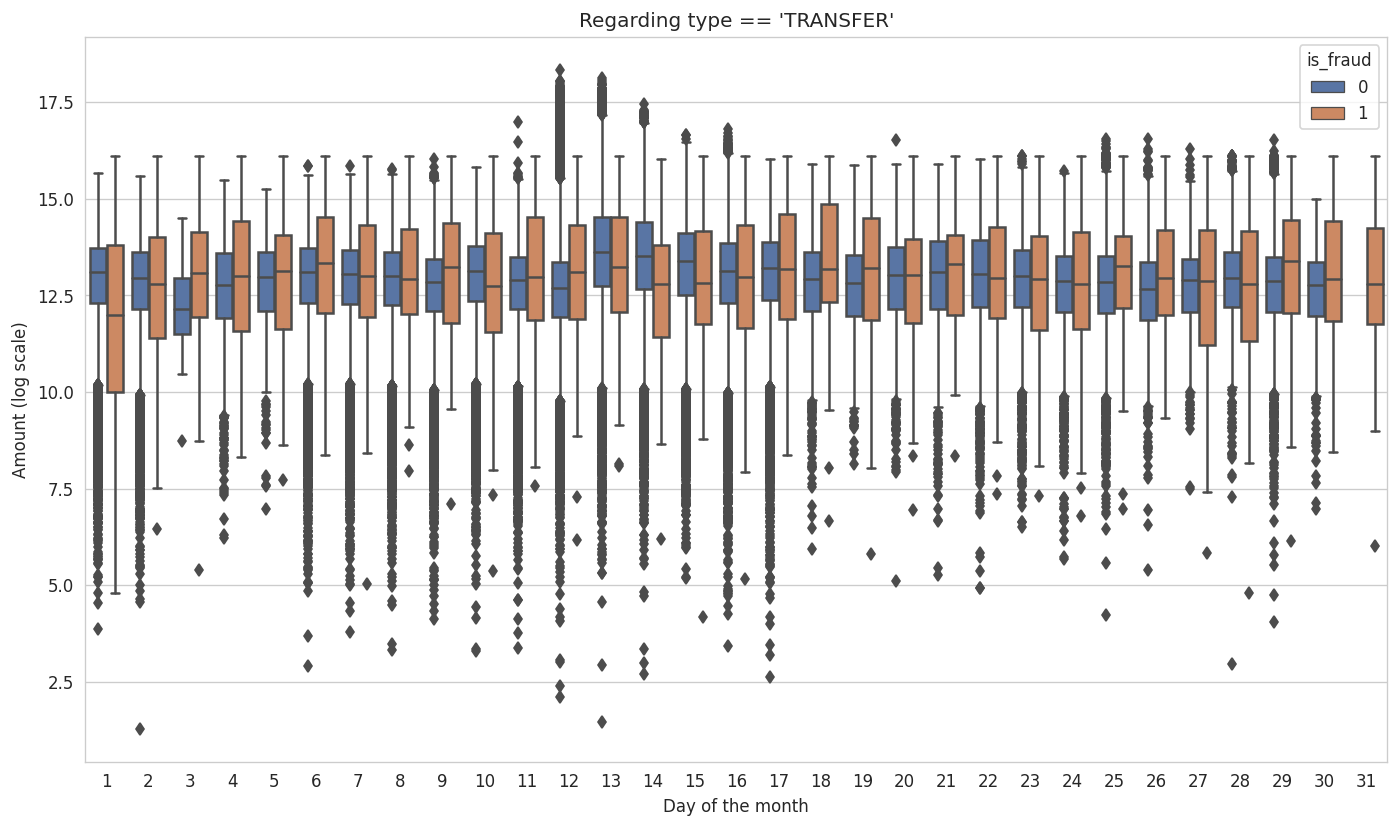

In [16]:
df_to_plot = fraud_detect_df[fraud_detect_df["type"] == "TRANSFER"]

boxplot_plot(
    x="day_of_month",
    y="amount_log", 
    data=df_to_plot, 
    hue="is_fraud", 
    xlabel="Day of the month", 
    ylabel="Amount (log scale)", 
    title="Regarding type == 'TRANSFER'", 
    horizontal=True
)


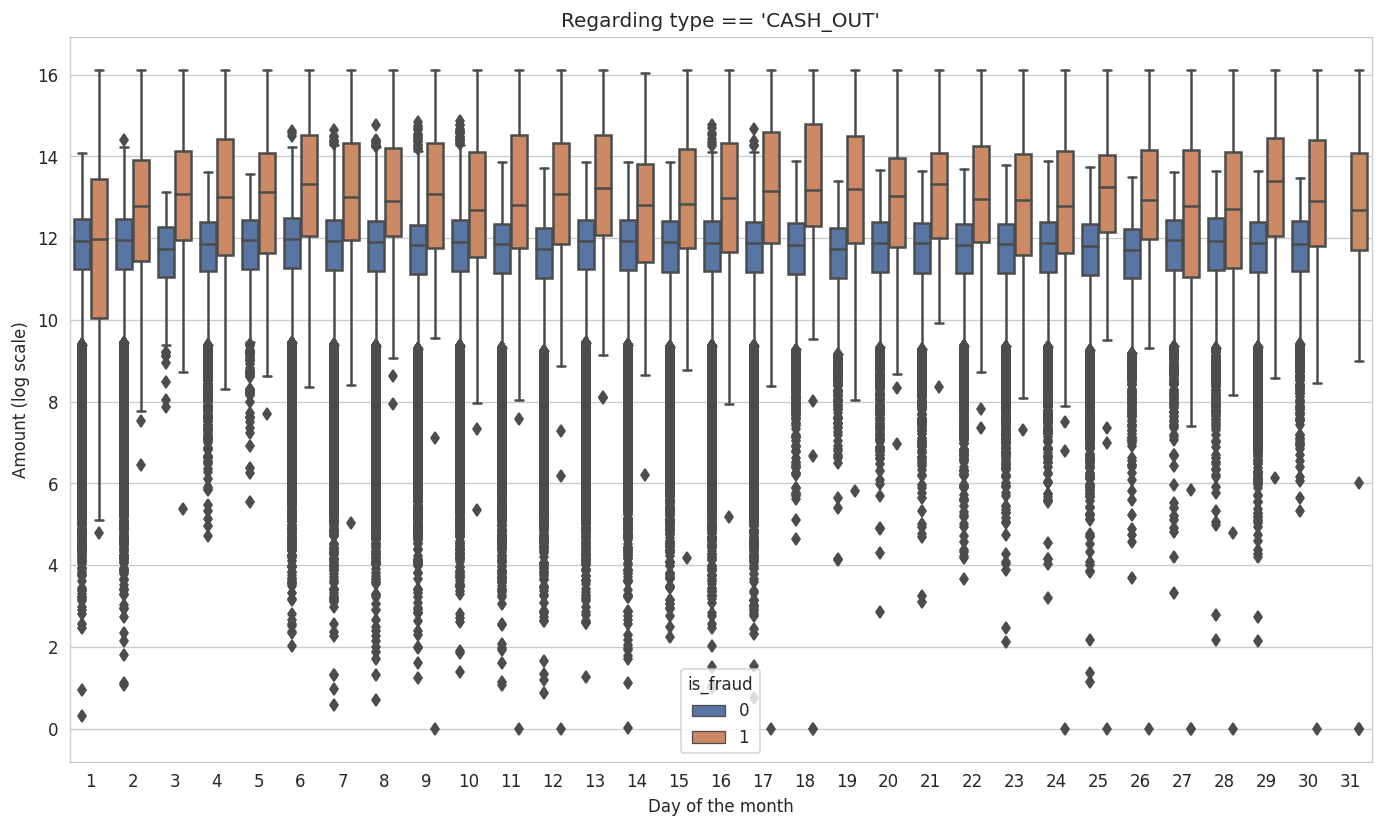

In [17]:
df_to_plot = fraud_detect_df[fraud_detect_df["type"] == "CASH_OUT"]

boxplot_plot(
    x="day_of_month",
    y="amount_log", 
    data=df_to_plot, 
    hue="is_fraud", 
    xlabel="Day of the month", 
    ylabel="Amount (log scale)", 
    title="Regarding type == 'CASH_OUT'", 
    horizontal=True
)

Was observed that the amount variable, is related just to the difference between origin and not the destination. So, let's add this variable to our dataset.

In [18]:
fraud_detect_df["amount_dest"] = abs((fraud_detect_df["old_balance_dest"]) - (fraud_detect_df["new_balance_dest"]))
fraud_detect_df["amount_dest_log"] = fraud_detect_df["amount_dest"].apply(log_transform)

And also, investigate the those boxplots.

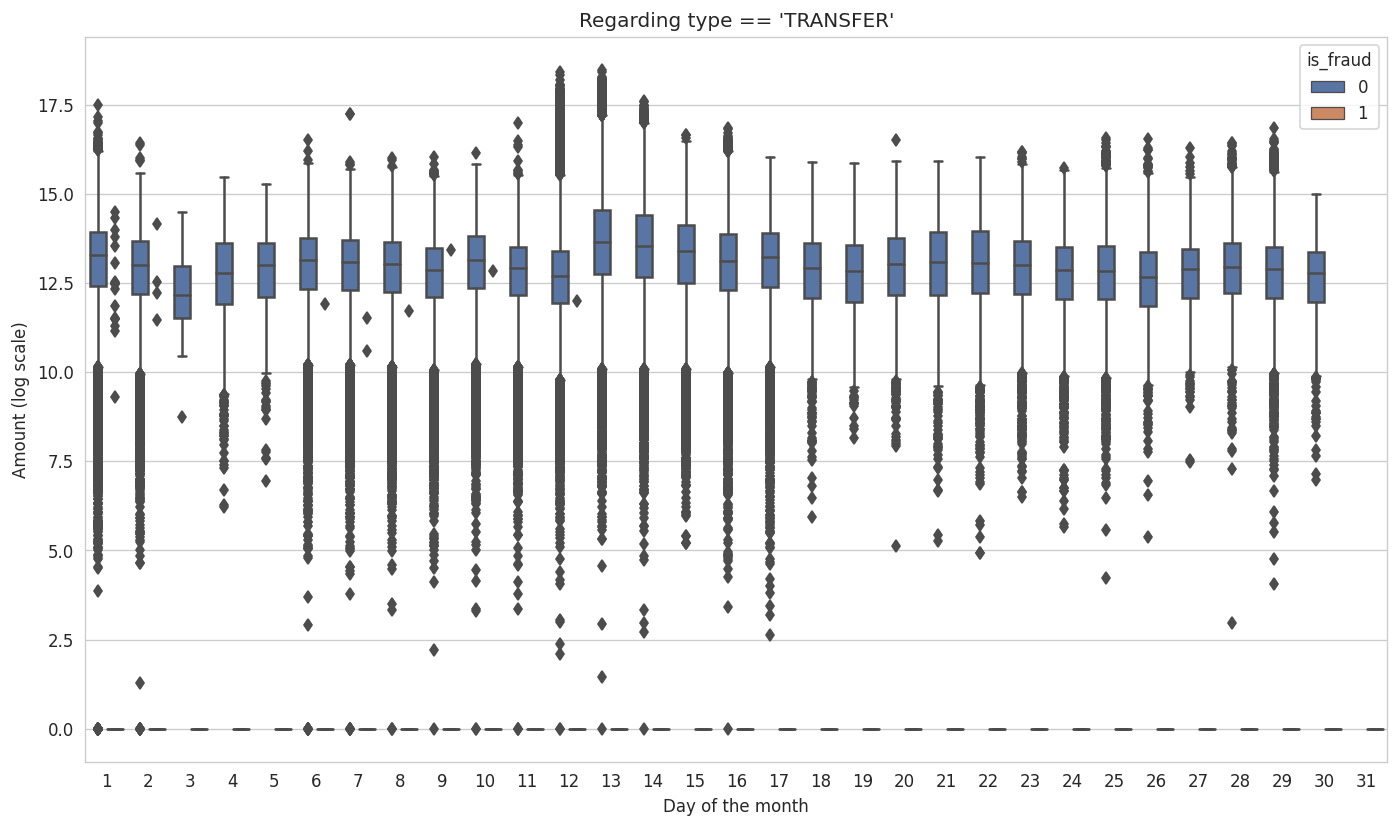

In [19]:
df_to_plot = fraud_detect_df[fraud_detect_df["type"] == "TRANSFER"]

boxplot_plot(
    x="day_of_month",
    y="amount_dest_log", 
    data=df_to_plot, 
    hue="is_fraud", 
    xlabel="Day of the month", 
    ylabel="Amount (log scale)", 
    title="Regarding type == 'TRANSFER'", 
    horizontal=True
)


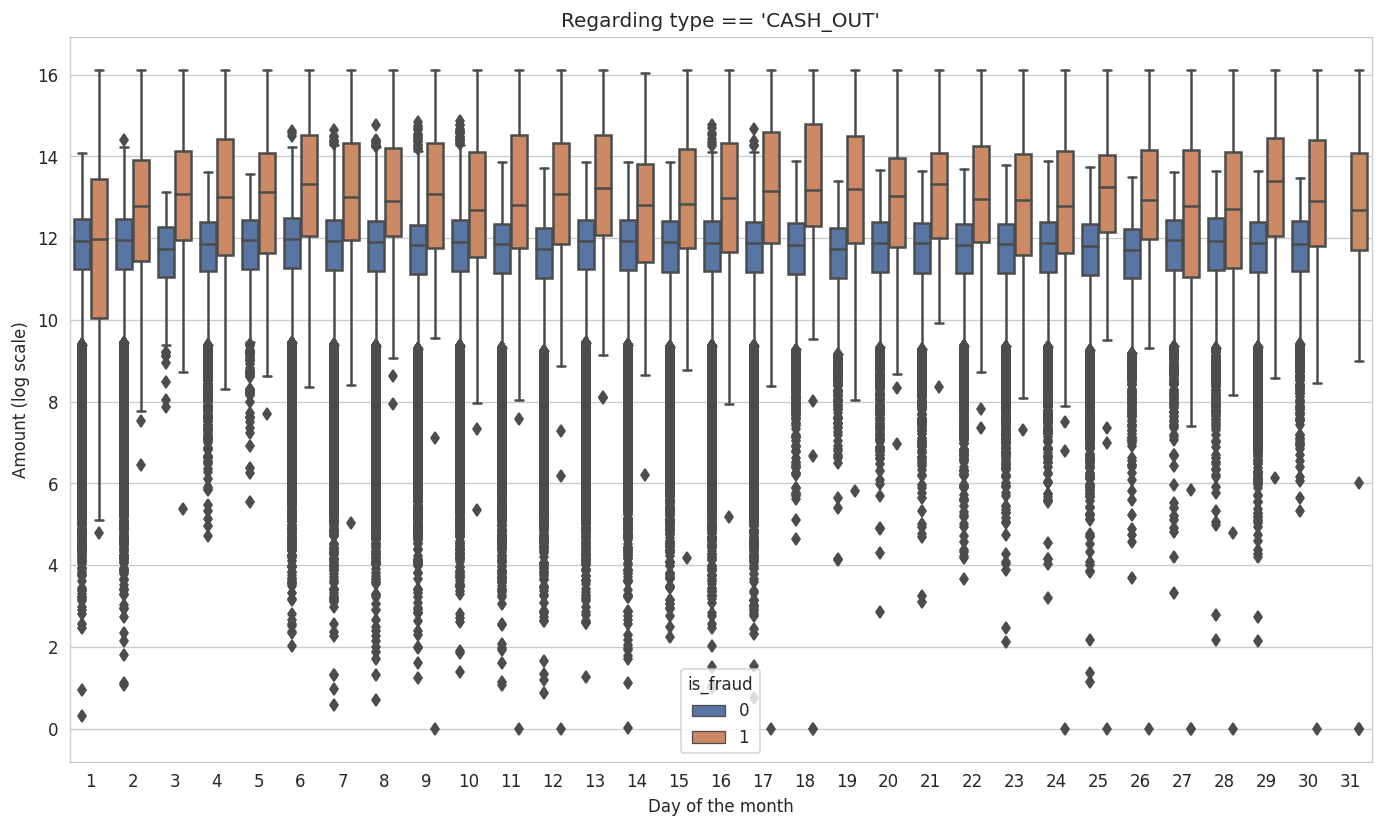

In [20]:
df_to_plot = fraud_detect_df[fraud_detect_df["type"] == "CASH_OUT"]

boxplot_plot(
    x="day_of_month",
    y="amount_log", 
    data=df_to_plot, 
    hue="is_fraud", 
    xlabel="Day of the month", 
    ylabel="Amount (log scale)", 
    title="Regarding type == 'CASH_OUT'", 
    horizontal=True
)

## Exporting our final dataset for modeling

In [21]:
final_fraud_df = fraud_detect_df[["day_of_month", "type", "amount_log", "amount_dest_log", "is_fraud"]]

In [22]:
final_fraud_df.to_csv("data/second-eda-output.csv", index=False)